<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/agni/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Example



## Requirements

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install wfdb
!pip install scikit-learn
!pip install matplotlib
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734983 sha256=d83c6de0a10896651b3e03aa

In [7]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram
from scipy.fft import rfft, rfftfreq, irfft
from sklearn.decomposition import FastICA
import os
import zipfile
import pyedflib

In [11]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/Fetal_ECG_Separation'
database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# train_dir = '/content/train/'
# os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


## Testing

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
Σχήμα signals: (300000, 5)


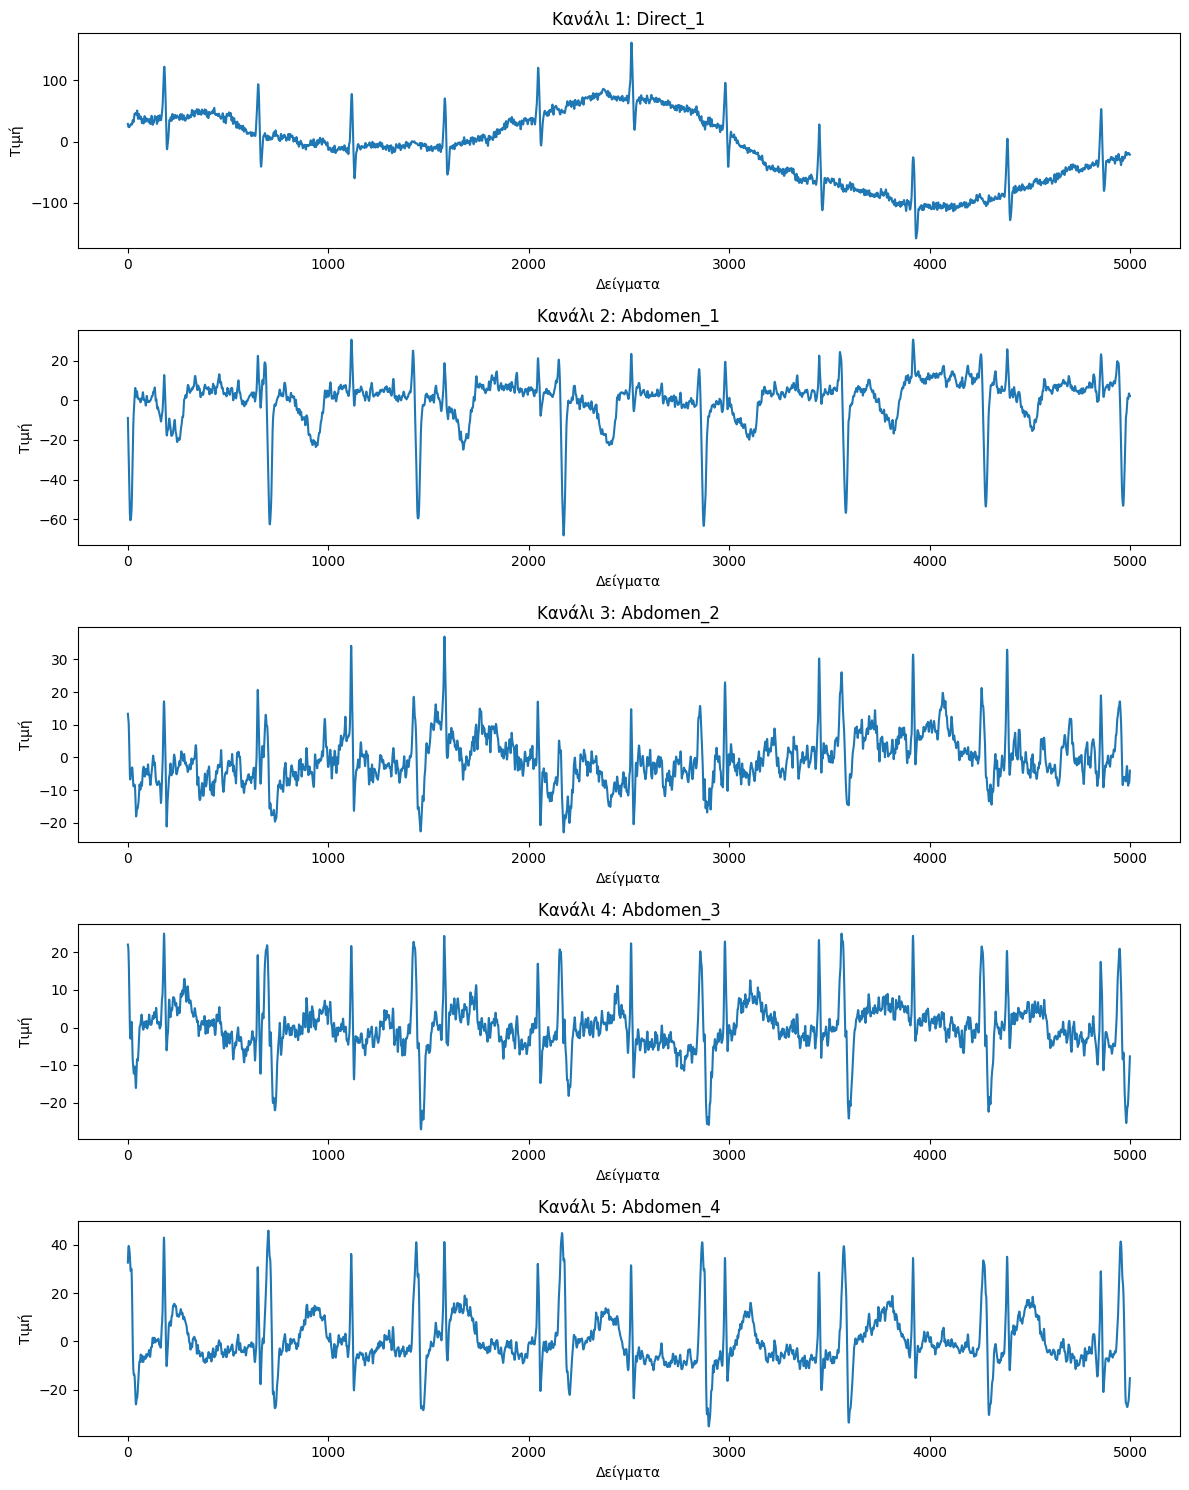

In [12]:
# Ορισμός της διαδρομής προς το EDF αρχείο
file_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Μετατροπή της λίστας σε NumPy array και transpose για να έχουμε σχήμα (δείγματα x κανάλια)
signals = np.array(signals_list).T
print("Σχήμα signals:", signals.shape)

# Επιλογή των πρώτων 5 δευτερολέπτων (για fs=1000, αυτό σημαίνει 5000 δείγματα)
n_sec = 5
first_n_sec = signals[:n_sec * int(fs), :]

# Οπτικοποίηση κάθε καναλιού σε διαφορετικό subplot
n_channels = first_n_sec.shape[1]
plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(first_n_sec[:, i])
    plt.title(f'Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')

plt.tight_layout()
plt.show()


In [13]:
# Load QRS annotations
qrs_annotations = wfdb.rdann("/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf", "qrs")

# Extract QRS peak sample indices
qrs_peaks = qrs_annotations.sample

print("QRS Peak Sample Indices:", qrs_peaks)

QRS Peak Sample Indices: [   183    651   1118   1583   2049   2514   2982   3451   3920   4389
   4857   5327   5796   6263   6732   7200   7667   8137   8603   9068
   9533   9999  10462  10926  11389  11848  12309  12767  13224  13680
  14137  14594  15047  15502  15954  16410  16863  17317  17773  18231
  18688  19143  19600  20058  20517  20975  21437  21903  22372  22840
  23308  23775  24244  24711  25173  25635  26096  26558  27021  27486
  27955  28425  28896  29365  29835  30306  30775  31243  31709  32174
  32639  33102  33565  34026  34488  34953  35416  35880  36344  36809
  37275  37743  38210  38678  39146  39617  40085  40557  41024  41493
  41961  42430  42899  43370  43843  44317  44790  45263  45736  46209
  46681  47152  47622  48094  48565  49036  49506  49974  50443  50910
  51377  51847  52312  52779  53246  53713  54179  54646  55107  55568
  56028  56491  56949  57409  57873  58334  58800  59266  59733  60201
  60669  61136  61606  62075  62539  63006  63469  6

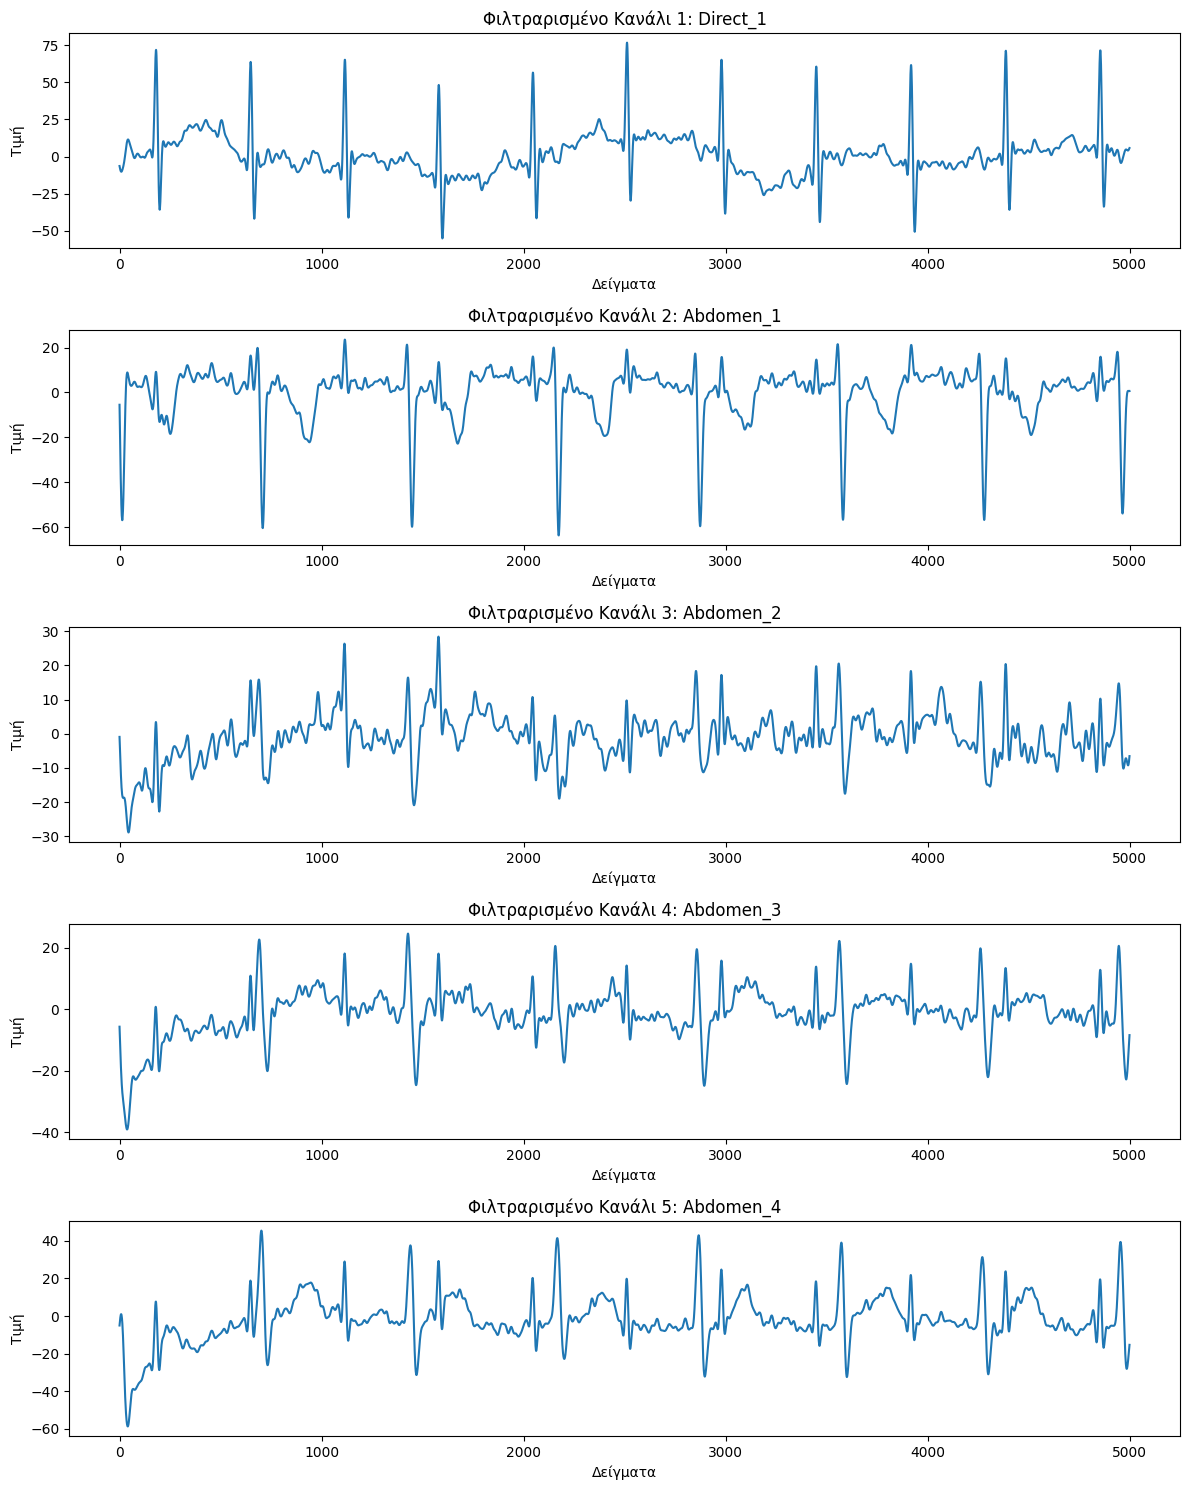

In [ ]:
# Συνάρτηση για ζωνοπερατό (bandpass) φιλτράρισμα
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # συχνότητα Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Ορισμός παραμέτρων φίλτρου
lowcut = 0.5   # Κατώφλι (Hz)
highcut = 40   # Άνω φράγμα (Hz)

# Εφαρμογή του φίλτρου σε κάθε κανάλι του σήματος
filtered_signals = np.zeros_like(signals)
for i in range(signals.shape[1]):
    filtered_signals[:, i] = bandpass_filter(signals[:, i], lowcut, highcut, fs, order=4)

# Οπτικοποίηση των φιλτραρισμένων σημάτων για τα πρώτα 5 δευτερόλεπτα
n_seconds = 5
first_n_sec_filtered = filtered_signals[:n_seconds * int(fs), :]
n_channels = first_n_sec_filtered.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(first_n_sec_filtered[:, i])
    plt.title(f'Φιλτραρισμένο Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

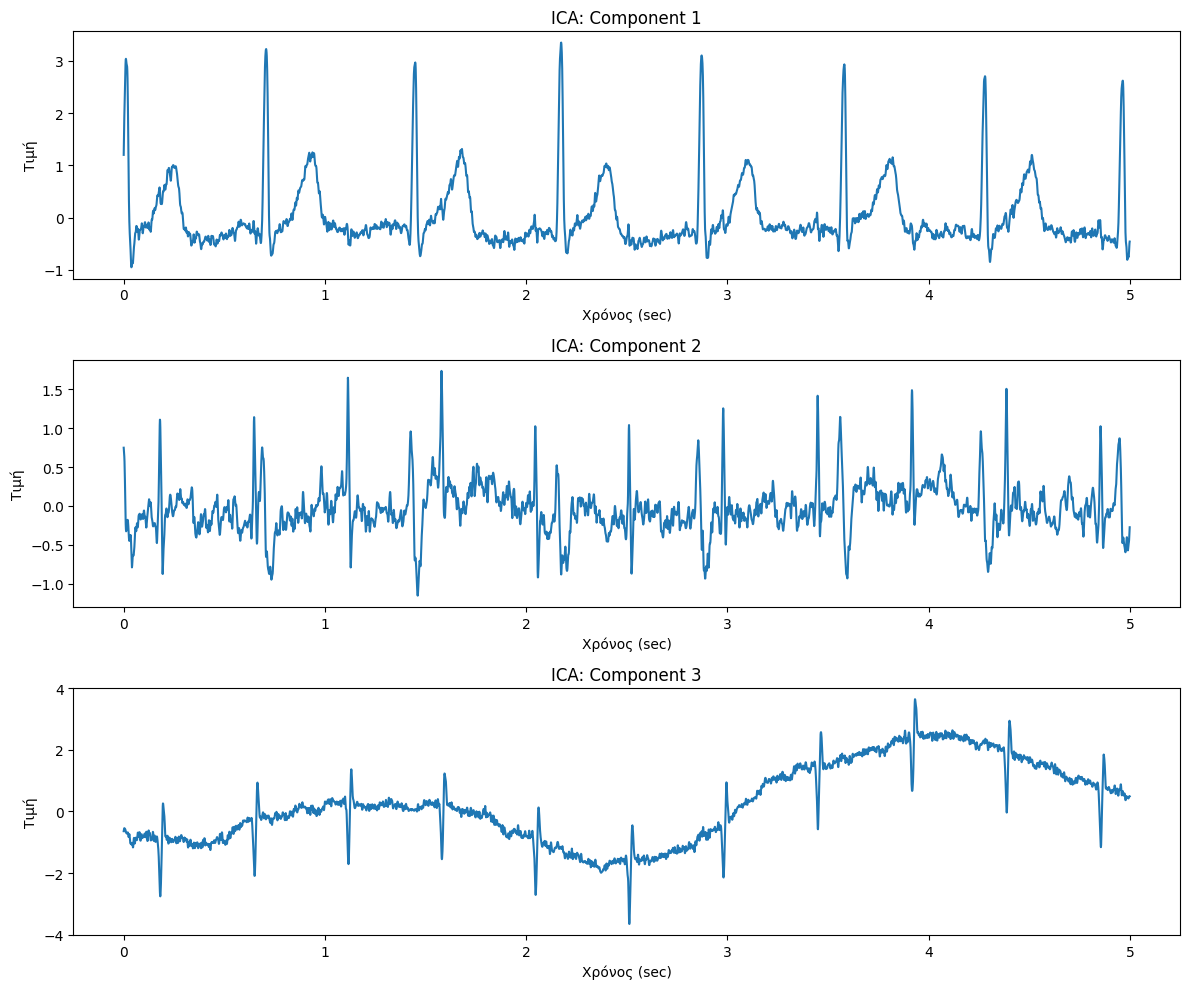

In [ ]:
# Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
ica = FastICA(n_components=3)
ica_components = ica.fit_transform(signals)  # ΟΧΙ filtered_signals !!!!!!!

# Οπτικοποίηση των αποτελεσμάτων (πρώτα 5 δευτερόλεπτα)
time = np.linspace(0, signals.shape[0]/fs, signals.shape[0])
first_n_sec_S = ica_components[:n_seconds * int(fs), :]

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(ica_components.shape[1], 1, i + 1)
    plt.plot(time[:n_seconds * int(fs)], first_n_sec_S[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Χρόνος (sec)')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

# FFT ✨

Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency (fs): 1000.0
Σχήμα signals: (300000, 5)


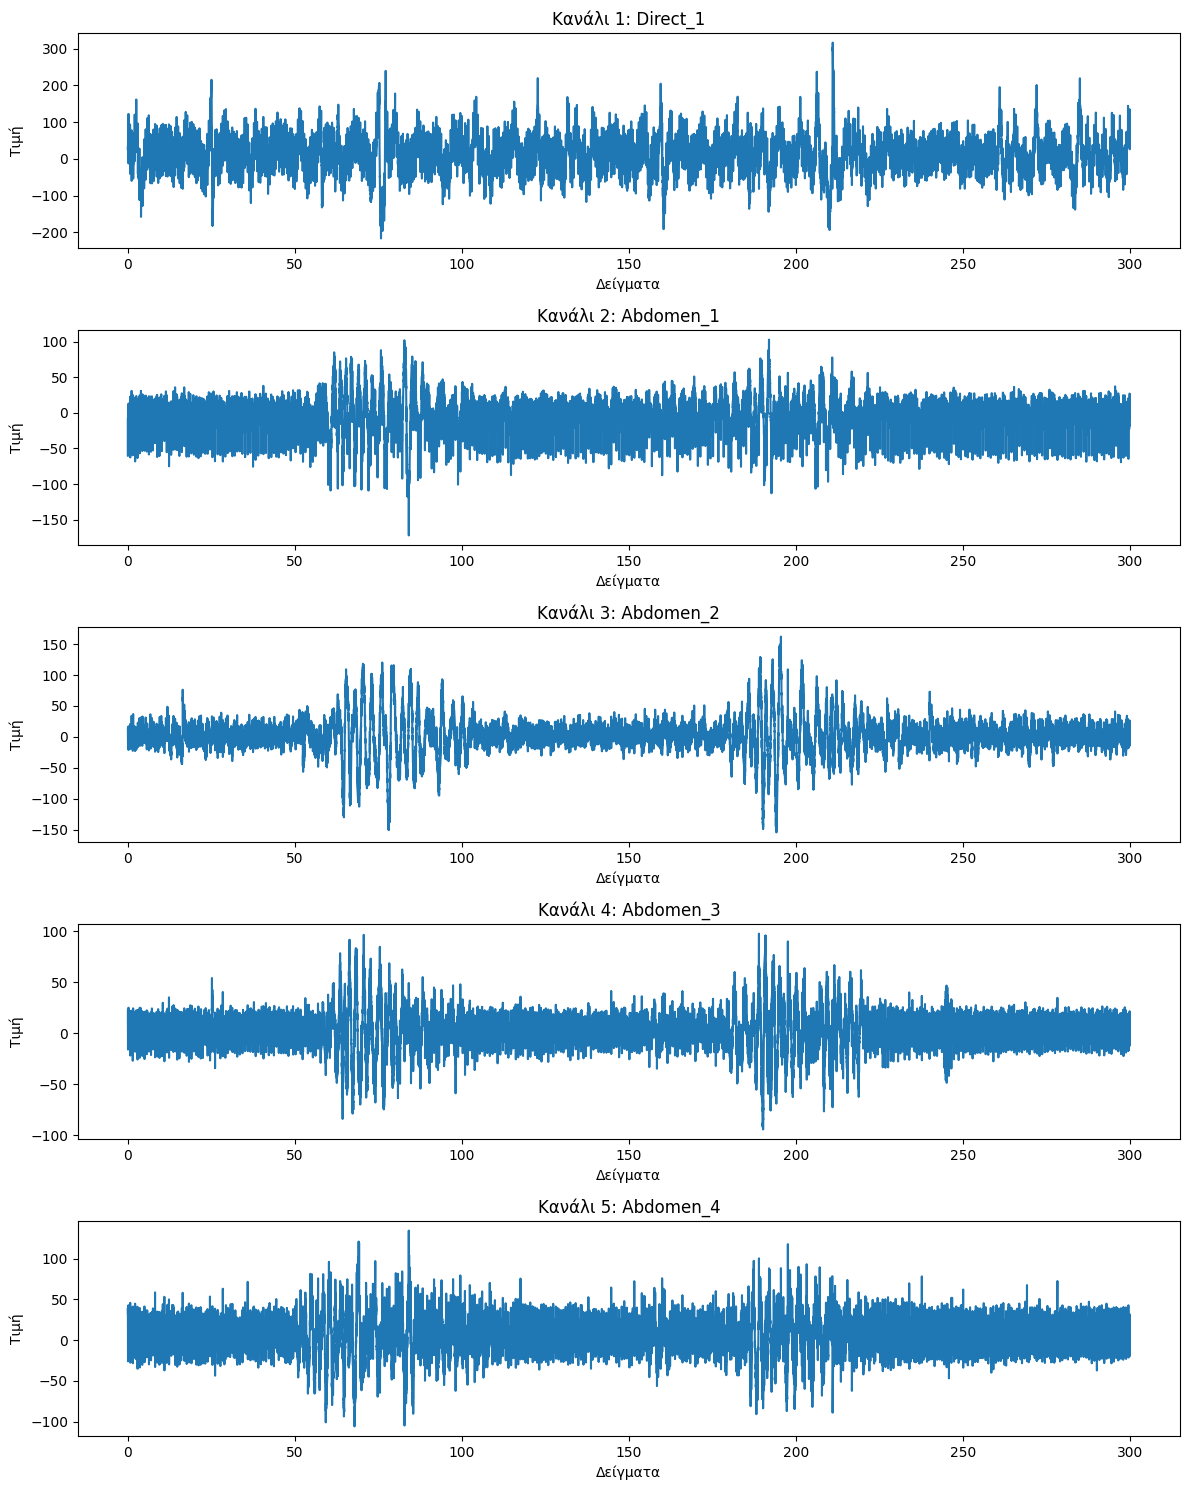

In [14]:
# Ορισμός της διαδρομής προς το EDF αρχείο
file_path = '/content/abdominal-and-direct-fetal-ecg-database-1.0.0/r01.edf'

# Άνοιγμα του EDF αρχείου
f = pyedflib.EdfReader(file_path)

# Εμφάνιση των ονομάτων των καναλιών
n_signals = f.signals_in_file
signal_labels = f.getSignalLabels()
print("Signal Labels:", signal_labels)

# Ανάγνωση όλων των καναλιών και αποθήκευση σε λίστα
signals_list = [f.readSignal(i) for i in range(n_signals)]
fs = f.getSampleFrequency(0)
print("Sampling frequency (fs):", fs)

f._close()  # Κλείσιμο του αρχείου

# Μετατροπή της λίστας σε NumPy array και transpose για να έχουμε σχήμα (δείγματα x κανάλια)
signals = np.array(signals_list).T
print("Σχήμα signals:", signals.shape)

n_samples = signals.shape[0]
time = np.arange(n_samples) / fs
n_channels = signals.shape[1]

plt.figure(figsize=(12, 3 * n_channels))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i + 1)
    plt.plot(time, signals[:, i])
    plt.title(f'Κανάλι {i+1}: {signal_labels[i]}')
    plt.xlabel('Δείγματα')
    plt.ylabel('Τιμή')

plt.tight_layout()
plt.show()


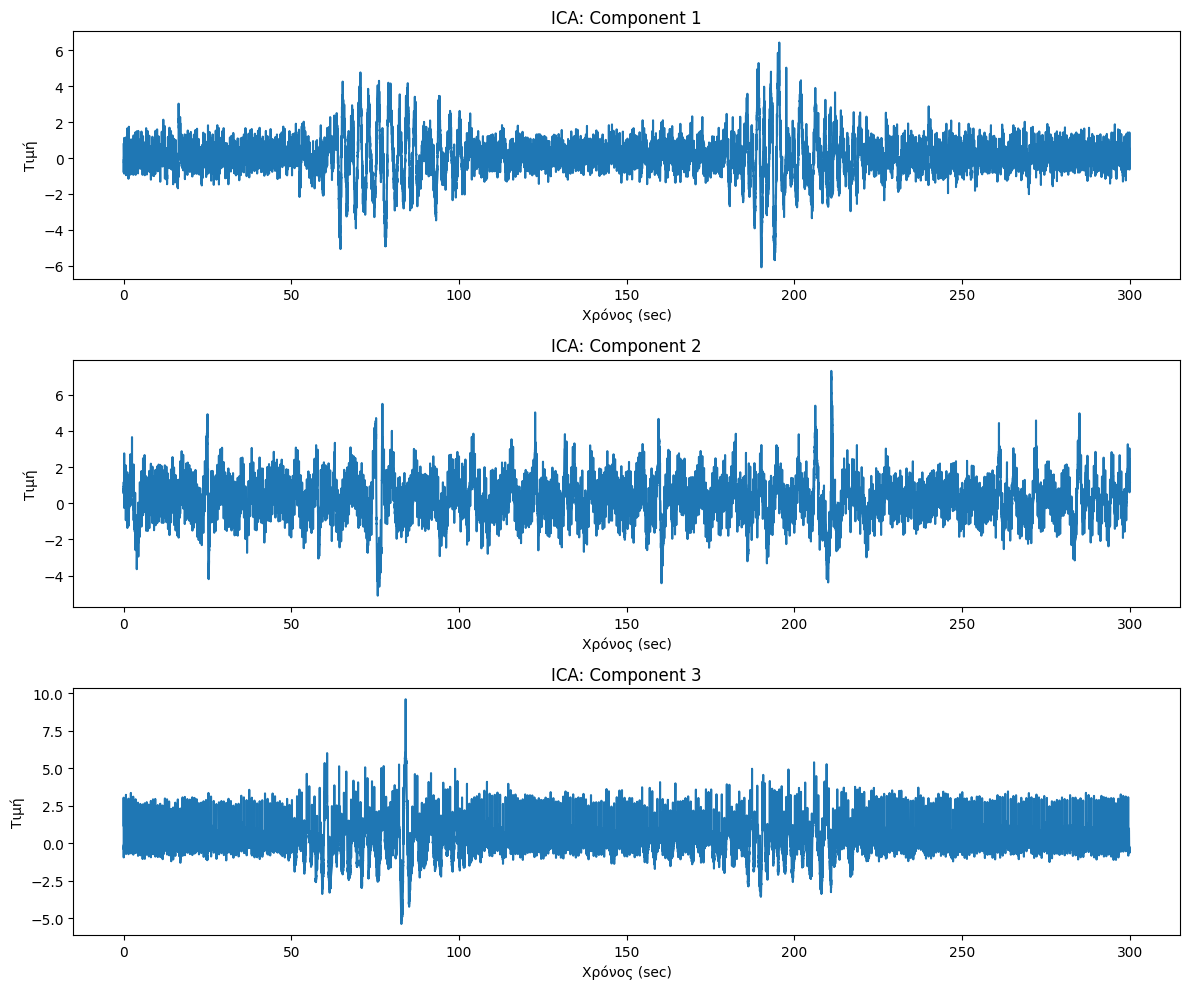

In [15]:
# Εφαρμογή ICA με αριθμό συστατικών (π.χ. 3)
n_components = 3

ica = FastICA(n_components)
ica_components = ica.fit_transform(signals)  # ΟΧΙ filtered_signals !!!!!!!

time = np.arange(ica_components.shape[0]) / fs

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(ica_components.shape[1], 1, i + 1)
    plt.plot(time, ica_components[:, i])
    plt.title(f'ICA: Component {i+1}')
    plt.xlabel('Χρόνος (sec)')
    plt.ylabel('Τιμή')
plt.tight_layout()
plt.show()

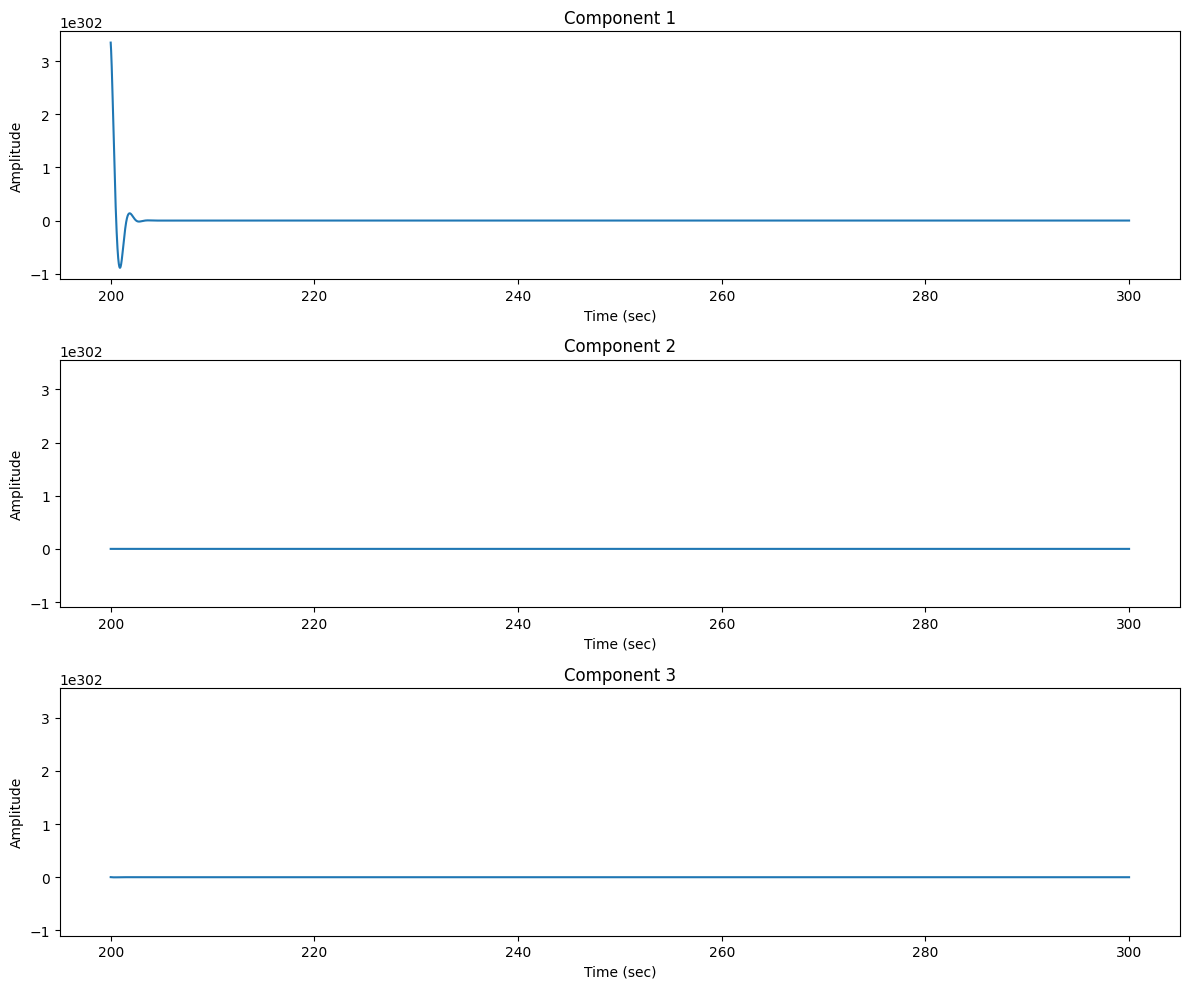

In [28]:
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs  # συχνότητα Nyquists
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[1]):
    filtered_signals[:, i] = bandpass_filter(
        data=ica_components[:, i],
        lowcut= 0.5,
        highcut=40,
        fs=fs,
        order=5
    )

fig, axes = plt.subplots(3, 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time[200000:], filtered_signals[200000:, i])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()


<ipython-input-21-b9c2996cea15>:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)


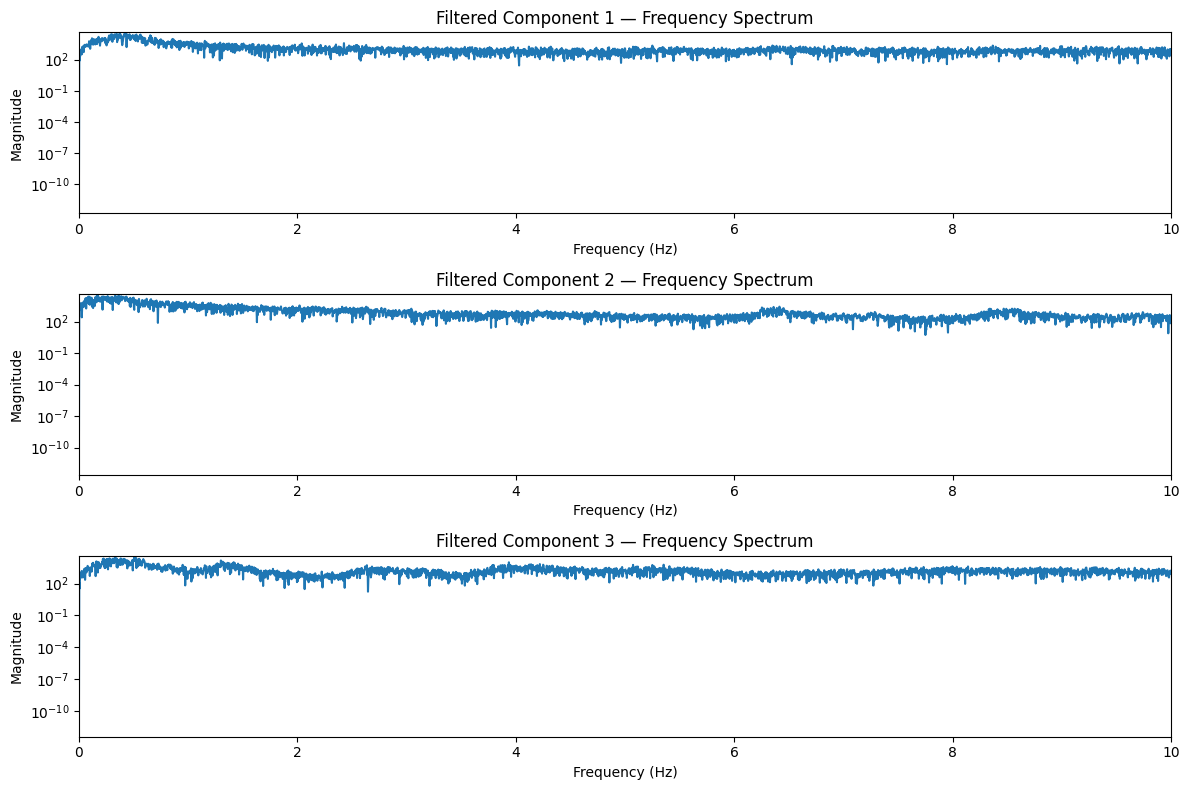

In [21]:
# Number of samples
n = ica_components.shape[0]

# Frequency axis
freqs = np.fft.rfftfreq(n, d=1/fs)

# Compute spectra
fft_vals_list = [
    np.abs(np.fft.rfft(ica_components[:, i]))
    for i in range(ica_components.shape[1])
]

# Replace any NaN or Inf with zero
fft_vals_list = [np.nan_to_num(vals, nan=0.0, posinf=0.0, neginf=0.0)
                 for vals in fft_vals_list]

# Global y‑limit
ymax = max(vals.max() for vals in fft_vals_list)

# Plot
plt.figure(figsize=(12, 8))
for i, fft_vals in enumerate(fft_vals_list):
    plt.subplot(ica_components.shape[1], 1, i+1)
    plt.plot(freqs, fft_vals)
    plt.title(f'Filtered Component {i+1} — Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.yscale('log')
    plt.ylabel('Magnitude')
    plt.xlim(0, 10)
    plt.ylim(0, ymax)
plt.tight_layout()
plt.show()



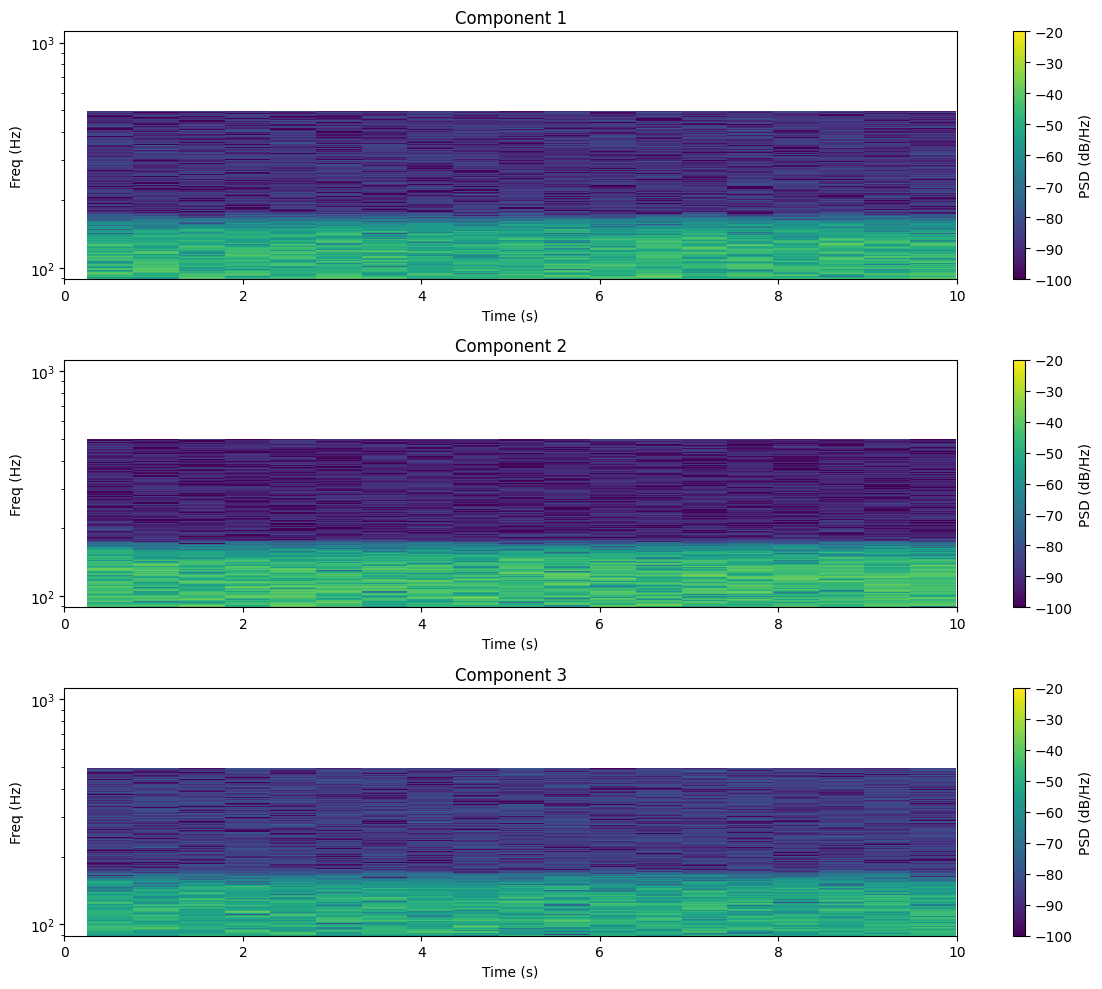

In [18]:
samples = int(50 * 1000)
NFFT = 1024
plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    plt.subplot(3, 1, i+1)
    plt.specgram(ica_components[:samples, i],
                 mode='psd', scale='dB',
                 NFFT=NFFT, Fs=fs, noverlap=NFFT//2,
                 vmin=-100, vmax=-20)
    plt.yscale('log')
    plt.colorbar(label='PSD (dB/Hz)')
    plt.title(f'Component {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.xlim(0, 10)

plt.tight_layout()
plt.show()

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.8 MB/s eta 0:00:00


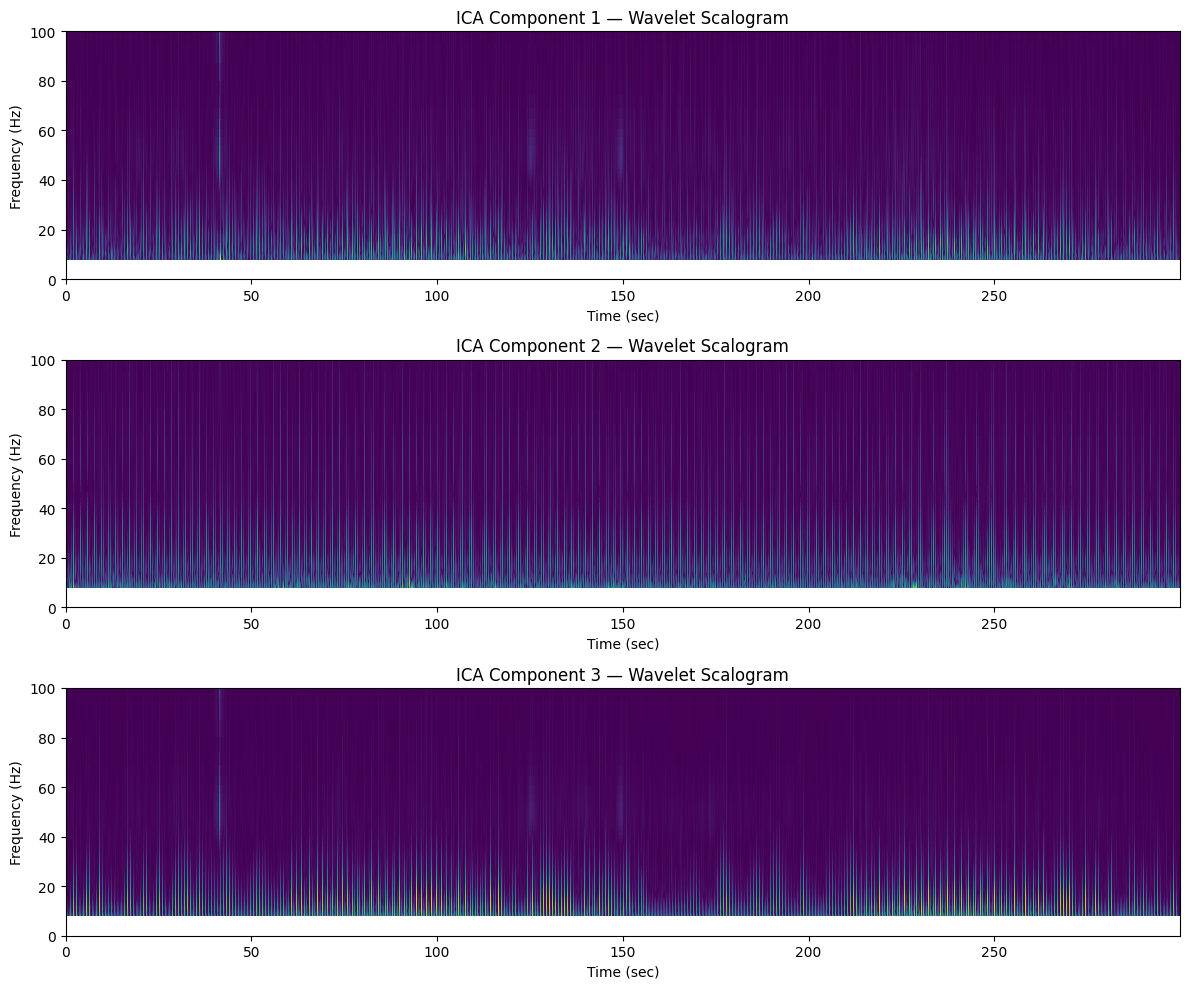

In [ ]:
import pywt

# Parameters
time = np.arange(ica_components.shape[0]) / fs

# Choose wavelet + scales
wavelet = 'cmor1.5-1.0'        # complex Morlet
scales = np.arange(1, 128)    # adjust max scale for resolution

plt.figure(figsize=(12, 10))

for i in range(ica_components.shape[1]):
    signal = ica_components[:, i]

    # Compute CWT
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)

    # Plot scalogram
    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)        # limit to fetal ECG band (~1–100 Hz)

plt.tight_layout()
plt.show()


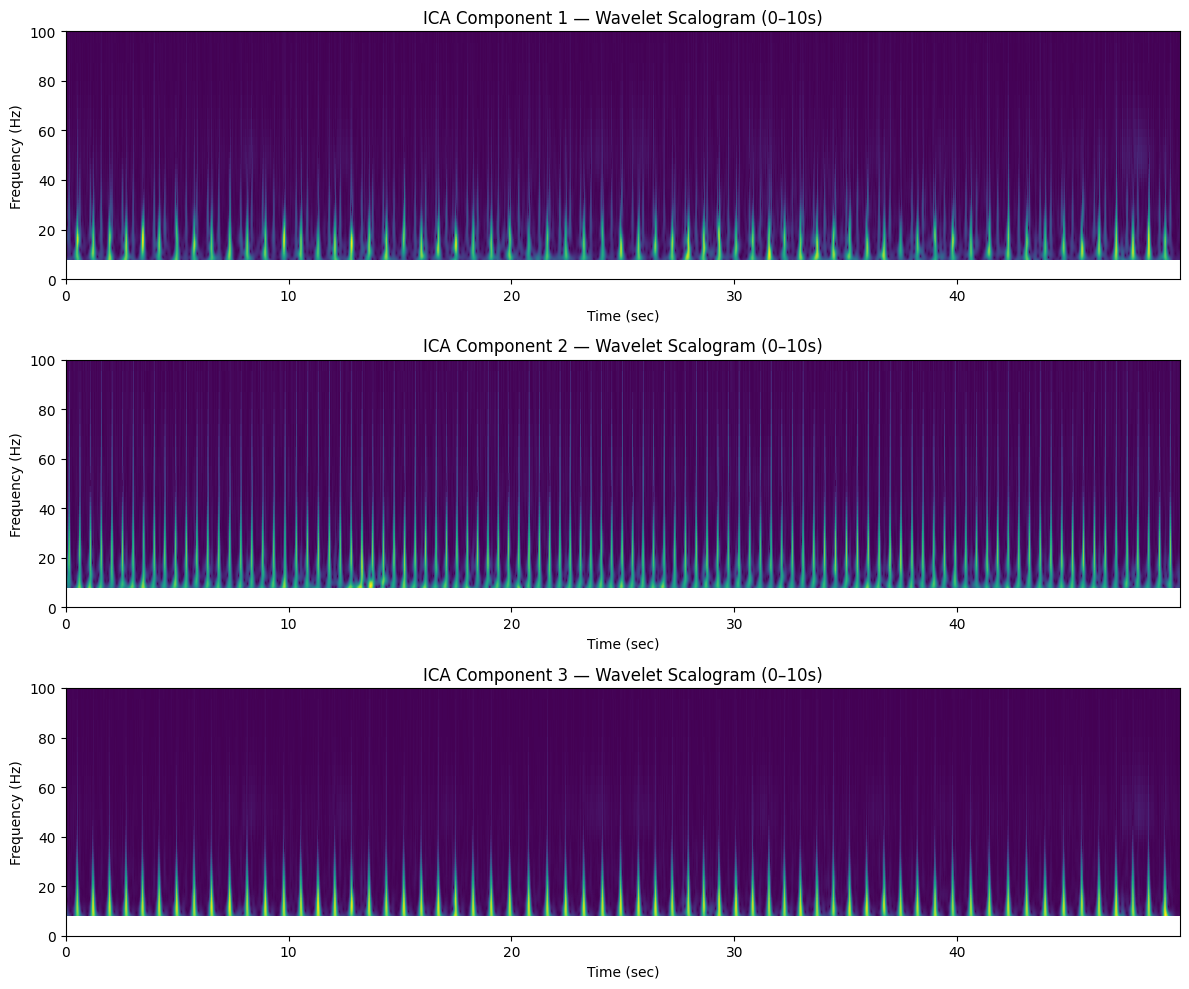

In [ ]:
end_idx = int(50 * fs)        # index corresponding to 10 seconds
time10 = time[:end_idx]       # first 10 seconds

plt.figure(figsize=(12, 10))
for i in range(ica_components.shape[1]):
    sig10 = ica_components[:end_idx, i]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time10, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# mean calc
#